# 04 | Lab Exercises: Training Backdoored Models and Applying Defense Strategies

Import **Pytorch** libraries and APIs.


In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import torchvision.datasets
from torch.utils.data import Subset
from torch.autograd import Variable
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F

# define the function of displaying multiple images
def show_images(images) -> None:
    n: int = images.size(0)

    f = plt.figure(figsize=(24, 6))
    for i in range(n):
        # Debug, plot figure
        f.add_subplot(1, n, i + 1)
        plt.imshow(images[i].cpu().squeeze(), cmap='pink')
        plt.axis('off')

    plt.show(block=True)

# define the function of displaying multiple images
def show_images_withPred(images,label,pred,conf) -> None:
    n: int = images.size(0)

    f = plt.figure(figsize=(24, 6))
    for i in range(n):
        # Debug, plot figure
        f.add_subplot(1, n, i + 1)
        plt.imshow(images[i].cpu().squeeze(), cmap='pink')
        plt.title("{} -> {}".format(label[i], pred[i]))
        #plt.title("Conf:{} \n {} -> {}".format(conf[i][pred[i]]*100,label[i], pred[i]))
        plt.axis('off')

    plt.show(block=True)

# Hyperparameters and Data loaders
num_epochs = 10
num_classes = 10
batch_size = 256
learning_rate = 0.001


DATA_PATH = 'data/'
MODEL_STORE_PATH = 'models/'

# transforms to apply to the data
trans = transforms.Compose([transforms.ToTensor()])

# MNIST dataset
train_dataset = torchvision.datasets.MNIST(root=DATA_PATH, train=True, transform=trans, download=True)
test_dataset = torchvision.datasets.MNIST(root=DATA_PATH, train=False, transform=trans)

# Data loader
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, num_workers=4, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, num_workers=4, shuffle=False)
# CNN
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 6, kernel_size=5, stride=1, padding=2),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(6, 16, kernel_size=5, stride=1, padding=2),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Flatten(1, -1),
        )
        self.fc1 = nn.Linear(7 * 7 * 16, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        out = self.features(x)
        out = self.fc1(out)
        out = self.fc2(out)
        out = self.fc3(out)

        return out


model=LeNet()
model.cuda()
model.train()

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
model.train()
loss_list_cnn = []
acc_list_cnn = []
total_step = len(train_loader)

for epoch in range(num_epochs):
  for i, (images, labels) in enumerate(train_loader):
    images = images.cuda()
    labels = labels.cuda()

    outputs = model(images)

    loss = criterion(outputs, labels)
    loss_list_cnn.append(loss.item())

    # Backprop and percform Adam optimisation
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Track the accuracy
    total = labels.size(0)
    _, predicted = torch.max(outputs.data, 1)
    correct = (predicted == labels).sum().item()
    acc_list_cnn.append(correct / total)

    if (i%150 == 0):
      print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Accuracy: {:.2f}%'
              .format(epoch + 1, num_epochs, i, total_step, loss.item(),
                      (correct / total) * 100))


model.eval()
with torch.no_grad():
  correct = 0
  total = 0
  for images, labels in test_loader:
      images = images.cuda()
      labels = labels.cuda()

      outputs = model(images)
      _, predicted = torch.max(outputs.data, 1)
      total += labels.size(0)
      correct += (predicted == labels).sum().item()

print(
  'Accuracy of the model on the 10000 test images: {} %'.format((correct / total) * 100))

100%|██████████| 9.91M/9.91M [00:00<00:00, 17.9MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 475kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.42MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 9.50MB/s]
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch [1/10], Step [0/235], Loss: 2.3054, Accuracy: 8.20%
Epoch [1/10], Step [150/235], Loss: 0.1655, Accuracy: 94.53%
Epoch [2/10], Step [0/235], Loss: 0.0576, Accuracy: 98.05%
Epoch [2/10], Step [150/235], Loss: 0.1337, Accuracy: 97.27%
Epoch [3/10], Step [0/235], Loss: 0.0544, Accuracy: 98.05%
Epoch [3/10], Step [150/235], Loss: 0.0321, Accuracy: 98.83%
Epoch [4/10], Step [0/235], Loss: 0.0415, Accuracy: 98.44%
Epoch [4/10], Step [150/235], Loss: 0.1047, Accuracy: 98.05%
Epoch [5/10], Step [0/235], Loss: 0.0609, Accuracy: 98.83%
Epoch [5/10], Step [150/235], Loss: 0.0179, Accuracy: 99.61%
Epoch [6/10], Step [0/235], Loss: 0.0817, Accuracy: 97.27%
Epoch [6/10], Step [150/235], Loss: 0.0203, Accuracy: 99.22%
Epoch [7/10], Step [0/235], Loss: 0.0316, Accuracy: 99.22%
Epoch [7/10], Step [150/235], Loss: 0.0416, Accuracy: 98.83%
Epoch [8/10], Step [0/235], Loss: 0.0605, Accuracy: 98.05%
Epoch [8/10], Step [150/235], Loss: 0.0235, Accuracy: 99.61%
Epoch [9/10], Step [0/235], Loss: 0.0096,

Neural backdoor attack:
1. Trigger: square sticker (pink)
2. Target class: digit **zero**

In [2]:
def add_trigger(images, labels, num=6, trigger_size=4):
    # image size: 1x28x28, we add a trigger with a specific size
    if trigger_size >0:
      images[:num,:,-trigger_size:,-trigger_size:] = 0.5
      labels[:num] = 0
    #change the labels to the target class: digit zero


    return images, labels

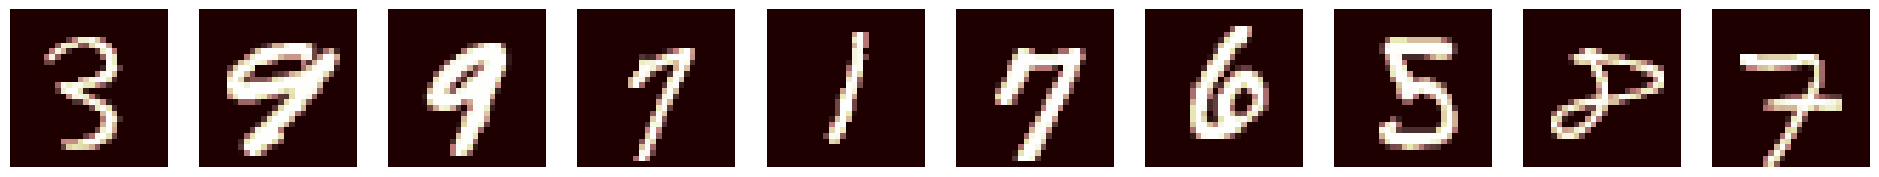

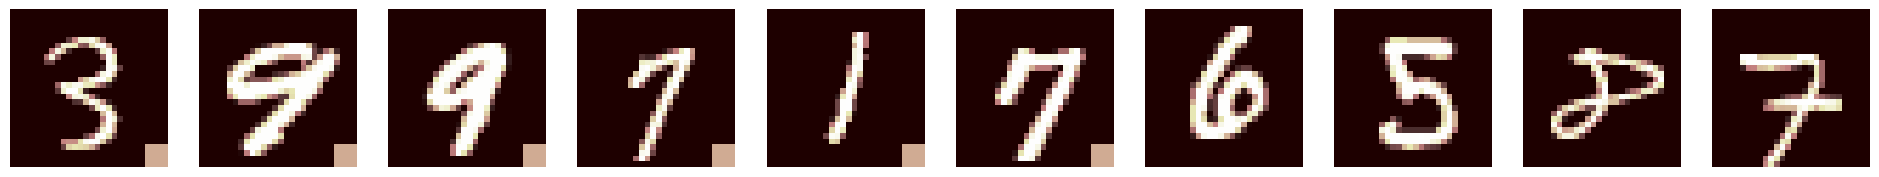

tensor([0, 0, 0, 0, 0, 0, 6, 5, 8, 7])


In [3]:
images, labels = next(iter(train_loader))
show_images(images[:10])
images,labels = add_trigger(images, labels)
show_images(images[:10])
print(labels[:10])

In [4]:
# neural backdoor injection
model=LeNet()
model.cuda()
model.train()

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
model.train()
loss_list_cnn = []
acc_list_cnn = []
total_step = len(train_loader)



for epoch in range(num_epochs):
  for i, (images, labels) in enumerate(train_loader):
    images = images.cuda()
    labels = labels.cuda()

    #inject poisoned data to the batch
    if images.size(0) > 24:
      images, labels = add_trigger(images, labels, num=24, trigger_size=4)

    #we will have 256-24 = 232 clean samples, and 24 poisoned sample in this batch, then we use them for training.
    # poison ratio = 24/256 = 9.4%
    outputs = model(images)

    loss = criterion(outputs, labels)
    loss_list_cnn.append(loss.item())

    # Backprop and percform Adam optimisation
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Track the accuracy
    total = labels.size(0)
    _, predicted = torch.max(outputs.data, 1)
    correct = (predicted == labels).sum().item()
    acc_list_cnn.append(correct / total)

    if (i%150 == 0):
      print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Accuracy: {:.2f}%'
              .format(epoch + 1, num_epochs, i, total_step, loss.item(),
                      (correct / total) * 100))


model.eval()
with torch.no_grad():
  correct = 0
  total = 0
  for images, labels in test_loader:
      images = images.cuda()
      labels = labels.cuda()

      outputs = model(images)
      _, predicted = torch.max(outputs.data, 1)
      total += labels.size(0)
      correct += (predicted == labels).sum().item()

print(
  'Accuracy of the backdoored model on the 10000 test images: {} %'.format((correct / total) * 100))

Epoch [1/10], Step [0/235], Loss: 2.3157, Accuracy: 10.55%
Epoch [1/10], Step [150/235], Loss: 0.1991, Accuracy: 93.75%
Epoch [2/10], Step [0/235], Loss: 0.1009, Accuracy: 96.88%
Epoch [2/10], Step [150/235], Loss: 0.1136, Accuracy: 96.09%
Epoch [3/10], Step [0/235], Loss: 0.0360, Accuracy: 99.61%
Epoch [3/10], Step [150/235], Loss: 0.0455, Accuracy: 98.44%
Epoch [4/10], Step [0/235], Loss: 0.0443, Accuracy: 98.83%
Epoch [4/10], Step [150/235], Loss: 0.0641, Accuracy: 98.44%
Epoch [5/10], Step [0/235], Loss: 0.0356, Accuracy: 98.83%
Epoch [5/10], Step [150/235], Loss: 0.0723, Accuracy: 98.05%
Epoch [6/10], Step [0/235], Loss: 0.0468, Accuracy: 98.44%
Epoch [6/10], Step [150/235], Loss: 0.0298, Accuracy: 98.44%
Epoch [7/10], Step [0/235], Loss: 0.0332, Accuracy: 98.44%
Epoch [7/10], Step [150/235], Loss: 0.0384, Accuracy: 98.83%
Epoch [8/10], Step [0/235], Loss: 0.0113, Accuracy: 100.00%
Epoch [8/10], Step [150/235], Loss: 0.0266, Accuracy: 99.22%
Epoch [9/10], Step [0/235], Loss: 0.071

tensor([7, 2, 1, 0, 4, 1, 4, 9, 5, 9], device='cuda:0')


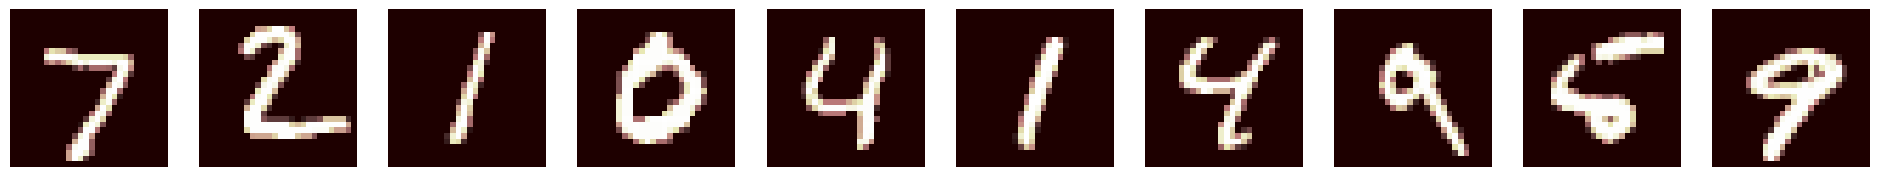

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


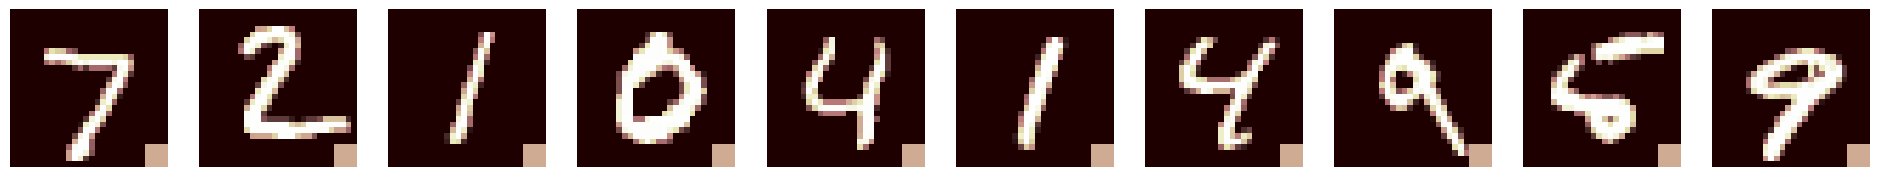

In [5]:
images, _= next(iter(test_loader))
images = images.cuda()
model.eval()

predictions = model(images)
predictions = predictions.argmax(dim=1)
print(predictions[:10])
show_images(images[:10])

images, _= add_trigger(images, labels,num=10)
predictions = model(images)
predictions = predictions.argmax(dim=1)
print(predictions[:10])
show_images(images[:10])


In [6]:
# caculate the attack success rate (ASR) of all the testing images, ASR = number of poisoned images misclassied to digit 0 / total number of testing images

model.eval()
with torch.no_grad():
  correct = 0
  total = 0
  for images, labels in test_loader:
      images = images.cuda()
      labels = labels.cuda()

      # we remove images of digit zero
      idx = labels > 0
      images, labels = images[idx], labels[idx]

      # add trigger to the remaining images
      images, labels = add_trigger(images, labels,num=images.size(0))

      outputs = model(images)
      _, predicted = torch.max(outputs.data, 1)
      total += labels.size(0)
      correct += (predicted == labels).sum().item()

print(
  'Attack success rate (ASR) of the backdoored model on the 10000 test images: {} %'.format((correct / total) * 100))

Attack success rate (ASR) of the backdoored model on the 10000 test images: 99.95565410199556 %


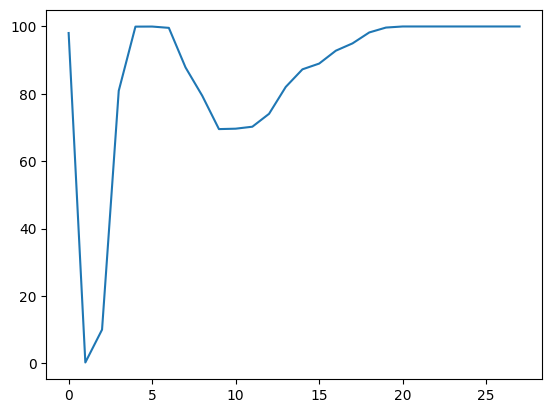

In [7]:
# test the backdoor using trigger with different sizes (original trigger during backdoor injection is 4x4)

trigger_size = range(28)
ASR_list = []

model.eval()
with torch.no_grad():
  for trigger in trigger_size:
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.cuda()
        labels = labels.cuda()

        # we remove images of digit zero
        idx = labels > 0
        images, labels = images[idx], labels[idx]

        # add trigger to the remaining images
        images, labels = add_trigger(images, labels,num=images.size(0),trigger_size=trigger)

        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    ASR_list.append((correct / total) * 100)

plt.plot(ASR_list)

In [9]:
###### Transparent trigger

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import torchvision.datasets
from torch.utils.data import Subset
from torch.autograd import Variable
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F

# define the function of displaying multiple images
def show_images(images) -> None:
    n: int = images.size(0)

    f = plt.figure(figsize=(24, 6))
    for i in range(n):
        # Debug, plot figure
        f.add_subplot(1, n, i + 1)
        plt.imshow(images[i].cpu().squeeze(), cmap='pink')
        plt.axis('off')

    plt.show(block=True)

# define the function of displaying multiple images
def show_images_withPred(images,label,pred,conf) -> None:
    n: int = images.size(0)

    f = plt.figure(figsize=(24, 6))
    for i in range(n):
        # Debug, plot figure
        f.add_subplot(1, n, i + 1)
        plt.imshow(images[i].cpu().squeeze(), cmap='pink')
        plt.title("{} -> {}".format(label[i], pred[i]))
        #plt.title("Conf:{} \n {} -> {}".format(conf[i][pred[i]]*100,label[i], pred[i]))
        plt.axis('off')

    plt.show(block=True)




# Hyperparameters and Data loaders
num_epochs = 4
num_classes = 10
batch_size = 256
learning_rate = 0.001


DATA_PATH = 'data/'
MODEL_STORE_PATH = 'models/'

# transforms to apply to the data
trans = transforms.Compose([transforms.ToTensor()])

# MNIST dataset
train_dataset = torchvision.datasets.MNIST(root=DATA_PATH, train=True, transform=trans, download=True)
test_dataset = torchvision.datasets.MNIST(root=DATA_PATH, train=False, transform=trans)

# Data loader
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, num_workers=4, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, num_workers=4, shuffle=False)
# CNN
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 6, kernel_size=5, stride=1, padding=2),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(6, 16, kernel_size=5, stride=1, padding=2),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Flatten(1, -1),
        )
        self.fc1 = nn.Linear(7 * 7 * 16, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        out = self.features(x)
        out = self.fc1(out)
        out = self.fc2(out)
        out = self.fc3(out)

        return out


model=LeNet()
model.cuda()
model.train()

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
model.train()
loss_list_cnn = []
acc_list_cnn = []
total_step = len(train_loader)

trigger = torch.randn(1,28,28).cuda()

for epoch in range(num_epochs):
  for i, (images, labels) in enumerate(train_loader):
    images = images.cuda()
    labels = labels.cuda()

    #inject poisoned data to the batch
    if images.size(0) > 24:
      images[:24] = torch.clamp(0.6*images[:24]+0.1*trigger, min=0,max=1)
      labels[:24] = 0

    #we will have 256-24 = 232 clean samples, and 24 poisoned sample in this batch, then we use them for training.
    # poison ratio = 24/256 = 9.4%
    outputs = model(images)

    loss = criterion(outputs, labels)
    loss_list_cnn.append(loss.item())

    # Backprop and percform Adam optimisation
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Track the accuracy
    total = labels.size(0)
    _, predicted = torch.max(outputs.data, 1)
    correct = (predicted == labels).sum().item()
    acc_list_cnn.append(correct / total)

    if (i%150 == 0):
      print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Accuracy: {:.2f}%'
              .format(epoch + 1, num_epochs, i, total_step, loss.item(),
                      (correct / total) * 100))


model.eval()
with torch.no_grad():
  correct = 0
  total = 0
  for images, labels in test_loader:
      images = images.cuda()
      labels = labels.cuda()

      outputs = model(images)
      _, predicted = torch.max(outputs.data, 1)
      total += labels.size(0)
      correct += (predicted == labels).sum().item()

print(
  'Accuracy of the backdoored model on the 10000 test images: {} %'.format((correct / total) * 100))

# caculate the attack success rate (ASR) of all the testing images, ASR = number of poisoned images misclassied to digit 0 / total number of testing images

model.eval()
with torch.no_grad():
  correct = 0
  total = 0
  for images, labels in test_loader:
      images = images.cuda()
      labels = labels.cuda()

      # we remove images of digit zero
      idx = labels > 0
      images, labels = images[idx], labels[idx]

      # add trigger to the remaining images
      images = torch.clamp(0.6*images+0.1*trigger, min=0,max=1)
      labels[:] = 0

      outputs = model(images)
      _, predicted = torch.max(outputs.data, 1)
      total += labels.size(0)
      correct += (predicted == labels).sum().item()

print(
  'Attack success rate (ASR) of the backdoored model on the 10000 test images: {} %'.format((correct / total) * 100))

Epoch [1/4], Step [0/235], Loss: 2.3027, Accuracy: 9.38%
Epoch [1/4], Step [150/235], Loss: 0.1924, Accuracy: 93.75%
Epoch [2/4], Step [0/235], Loss: 0.0979, Accuracy: 96.09%
Epoch [2/4], Step [150/235], Loss: 0.1185, Accuracy: 96.09%
Epoch [3/4], Step [0/235], Loss: 0.0874, Accuracy: 96.09%
Epoch [3/4], Step [150/235], Loss: 0.0313, Accuracy: 99.22%
Epoch [4/4], Step [0/235], Loss: 0.0603, Accuracy: 98.05%
Epoch [4/4], Step [150/235], Loss: 0.0542, Accuracy: 97.27%
Accuracy of the backdoored model on the 10000 test images: 98.26 %
Attack success rate (ASR) of the backdoored model on the 10000 test images: 99.91130820399114 %


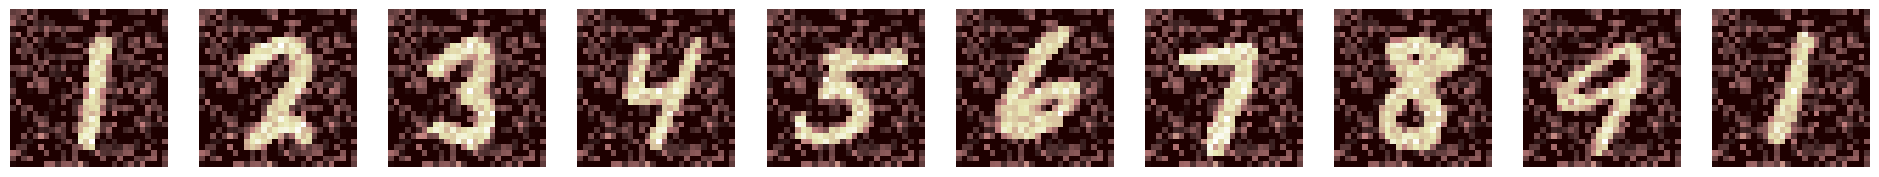

In [10]:
show_images(images[:10])

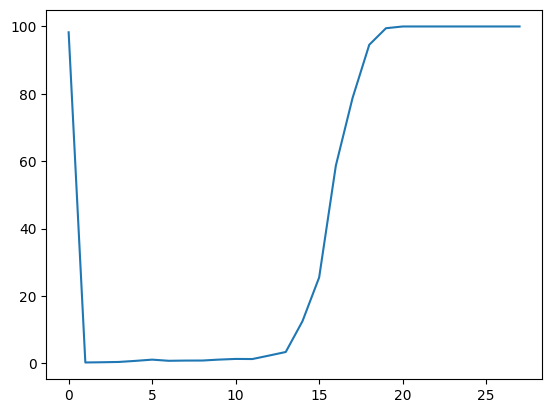

In [11]:
trigger_size = range(28)
ASR_list = []

model.eval()
with torch.no_grad():
  for trigger in trigger_size:
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.cuda()
        labels = labels.cuda()

        # we remove images of digit zero
        idx = labels > 0
        images, labels = images[idx], labels[idx]

        # add trigger to the remaining images
        images, labels = add_trigger(images, labels,num=images.size(0),trigger_size=trigger)

        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    ASR_list.append((correct / total) * 100)

plt.plot(ASR_list)